In [ ]:
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

In [ ]:
#Load the dataset from TensorFlow Datasets
(train_dataset,validation_dataset), info=tfds.load(
    'plant_village',
    split=['train[:80%]','train[80%:]'],
    with_info=True,
    as_supervised=True, #gives (images,label)
)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Extraction completed...: 0 file [00:00, ? file/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...: 0 examples [00:00, ? examples/s]

Shuffling /root/tensorflow_datasets/plant_village/incomplete.GJK3JB_1.0.2/plant_village-train.tfrecord*...:   …

Dataset plant_village downloaded and prepared to /root/tensorflow_datasets/plant_village/1.0.2. Subsequent calls will reuse this data.


In [ ]:
print("Number of Classes: ",info.features['label'].num_classes)
print("Class names: ",info.features['label'].names)

Number of Classes:  38
Class names:  ['Apple___Apple_scab', 'Apple___Black_rot', 'Apple___Cedar_apple_rust', 'Apple___healthy', 'Blueberry___healthy', 'Cherry___healthy', 'Cherry___Powdery_mildew', 'Corn___Cercospora_leaf_spot Gray_leaf_spot', 'Corn___Common_rust', 'Corn___healthy', 'Corn___Northern_Leaf_Blight', 'Grape___Black_rot', 'Grape___Esca_(Black_Measles)', 'Grape___healthy', 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)', 'Orange___Haunglongbing_(Citrus_greening)', 'Peach___Bacterial_spot', 'Peach___healthy', 'Pepper,_bell___Bacterial_spot', 'Pepper,_bell___healthy', 'Potato___Early_blight', 'Potato___healthy', 'Potato___Late_blight', 'Raspberry___healthy', 'Soybean___healthy', 'Squash___Powdery_mildew', 'Strawberry___healthy', 'Strawberry___Leaf_scorch', 'Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___healthy', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Toma

In [ ]:
# Constants
IMAGE_SIZE = (224, 224)
BATCH_SIZE = 32
AUTOTUNE = tf.data.AUTOTUNE

# Preprocessing function
def preprocess(image, label):
    image = tf.image.resize(image, IMAGE_SIZE)
    image = image / 255.0  # normalize pixels to [0, 1]
    return image, label

# Apply preprocessing and prepare dataset
train_dataset = (
    train_dataset.map(preprocess)
    .shuffle(1000)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

validation_dataset = (
    validation_dataset.map(preprocess)
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)


In [ ]:
# Data augmentation to improve generalization
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])


In [ ]:
# Load pretrained MobileNetV2 model without top layers
base_model = tf.keras.applications.MobileNetV2(
    input_shape=(224, 224, 3),
    include_top=False,
    weights='imagenet'
)

# Freeze all layers initially
base_model.trainable = False


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Create full model architecture
model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape=(224, 224, 3)),
    data_augmentation,
    base_model,
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(info.features['label'].num_classes, activation='softmax')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()


/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/input_layer.py:27: UserWarning: Argument `input_shape` is deprecated. Use `shape` instead.
  warnings.warn(


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ sequential (Sequential)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 7, 7, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 38)             │        48,678 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,306,662 (8.80 MB)

 Trainable params: 48,678 (190.15 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [ ]:
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

# Auto-save the best model and stop early if no improvement
checkpoint_cb = ModelCheckpoint(
    filepath='krishi_mitra_checkpoint.keras',
    save_best_only=True,
    monitor='val_accuracy',
    mode='max',
    verbose=1
)

earlystop_cb = EarlyStopping(
    monitor='val_accuracy',
    patience=5,  # stop if no improvement for 5 epochs
    restore_best_weights=True
)

callbacks = [checkpoint_cb, earlystop_cb]


In [ ]:
from tensorflow import keras

# Load the saved model
model = keras.models.load_model('krishi_mitra_after_epoch2.keras')

# Continue training from epoch 3
history = model.fit(
    train_dataset,
    validation_data=validation_dataset,
    epochs=10,           # total epochs to reach
    initial_epoch=2,     # start from epoch 3
    callbacks=callbacks
)


Epoch 3/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 898ms/step - accuracy: 0.9212 - loss: 0.2474
Epoch 3: val_accuracy improved from -inf to 0.92284, saving model to krishi_mitra_checkpoint.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1467s 1s/step - accuracy: 0.9212 - loss: 0.2474 - val_accuracy: 0.9228 - val_loss: 0.2385
Epoch 4/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 928ms/step - accuracy: 0.9201 - loss: 0.2407
Epoch 4: val_accuracy improved from 0.92284 to 0.93518, saving model to krishi_mitra_checkpoint.keras
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1517s 1s/step - accuracy: 0.9201 - loss: 0.2407 - val_accuracy: 0.9352 - val_loss: 0.1928
Epoch 5/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 915ms/step - accuracy: 0.9262 - loss: 0.2210
Epoch 5: val_accuracy did not improve from 0.93518
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 1491s 1s/step - accuracy: 0.9262 - loss: 0.2210 - val_accuracy: 0.9343 - val_loss: 0.2018
Epoch 6/10
1358/1358 ━━━━━━━━━━━━━━━━━━━━ 0s 913ms/step - accuracy: 0.9268 - loss: 0.2190
Epoch 6: val_accuracy imp

In [ ]:
model.save('krishi_mitra_after_epoch2.keras')
print("✅ Model saved successfully after Epoch 2!")


✅ Model saved successfully after Epoch 2!


In [ ]:
import tensorflow as tf
model = tf.keras.models.load_model('krishi_mitra_checkpoint.keras')
model.save('krishi_mitra_final_model.keras')
print("✅ Final trained model saved successfully!")


✅ Final trained model saved successfully!


In [ ]:
val_loss, val_acc = model.evaluate(validation_dataset)
print(f"Validation Accuracy: {val_acc*100:.2f}%")
print(f"Validation Loss: {val_loss:.4f}")


340/340 ━━━━━━━━━━━━━━━━━━━━ 216s 628ms/step - accuracy: 0.9425 - loss: 0.1777
Validation Accuracy: 94.33%
Validation Loss: 0.1734


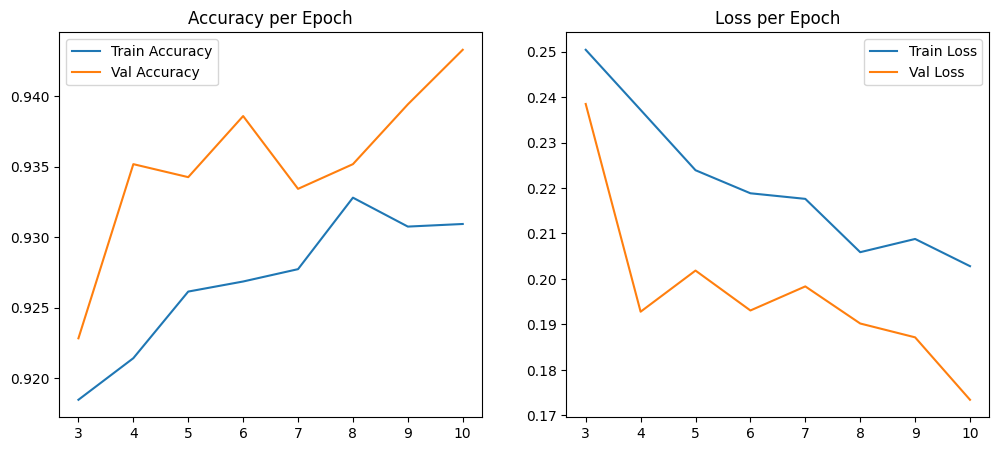

In [ ]:
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(3, 11)  # since you started from epoch 3

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(epochs, acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Val Accuracy')
plt.legend(); plt.title('Accuracy per Epoch')

plt.subplot(1,2,2)
plt.plot(epochs, loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Val Loss')
plt.legend(); plt.title('Loss per Epoch')
plt.show()


In [ ]:
from google.colab import files
uploaded = files.upload()


Saving image (10).JPG to image (10).JPG


In [ ]:
from PIL import Image
img = Image.open('image (10).JPG').resize((224, 224))


In [ ]:
import numpy as np
img = np.array(img)/255.0
img = np.expand_dims(img, axis=0)

# Predict
pred = model.predict(img)
predicted_class = np.argmax(pred)
print("Predicted class:", info.features['label'].int2str(predicted_class))


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Predicted class: Tomato___Bacterial_spot


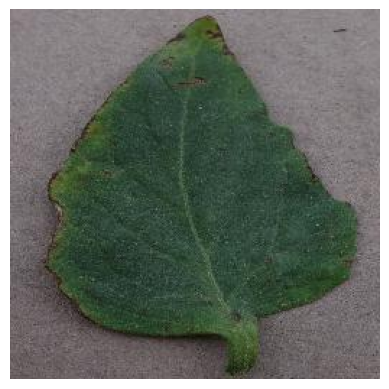

In [ ]:
import matplotlib.pyplot as plt

plt.imshow(Image.open('image (10).JPG'))
plt.axis('off')
plt.show()


In [3]:
import tensorflow as tf

# Load your trained model (with data_augmentation)
trained_model = tf.keras.models.load_model('krishi_mitra_final_model.keras')

# Let's inspect the layer names (optional check)
for i, layer in enumerate(trained_model.layers):
    print(i, layer.name, type(layer))

# Extract the correct layers (based on printed list)
base_model = trained_model.layers[1]   # MobileNetV2 backbone
gap = trained_model.layers[2]          # GlobalAveragePooling2D
dropout = trained_model.layers[3]      # Dropout layer
dense = trained_model.layers[4]        # Dense softmax layer

# Build a new "inference" model without data augmentation
inputs = tf.keras.Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = gap(x)
x = dropout(x)
outputs = dense(x)

inference_model = tf.keras.Model(inputs, outputs)

# Save this clean model for backend
inference_model.save('krishi_mitra_inference_model.keras')
print("✅ Clean inference model saved successfully!")


0 sequential <class 'keras.src.models.sequential.Sequential'>
1 mobilenetv2_1.00_224 <class 'keras.src.models.functional.Functional'>
2 global_average_pooling2d <class 'keras.src.layers.pooling.global_average_pooling2d.GlobalAveragePooling2D'>
3 dropout <class 'keras.src.layers.regularization.dropout.Dropout'>
4 dense <class 'keras.src.layers.core.dense.Dense'>
✅ Clean inference model saved successfully!
